In [154]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import math
#from numba import jit

Want to evolve system:
\begin{equation}
    \begin{cases}
    i \hbar \frac{\partial \psi(\vec{x},t)}{\partial t} = \hat{H}\psi(\vec{x},t)\\
    \nabla^2 \Phi = 4 \pi G \rho = 4 \pi G |\psi|^2
    \end{cases}
\end{equation}

Given Hamiltonian:
$$
\hat{H} = \frac{-\hbar^2}{2m}\nabla^2 + \Phi(\vec{x},t)
$$

And with periodic (spatial) boundary conditions on $\Psi$.

Also, set $m = \hbar = 4\pi G = 1$.

Then, for a small time step $\Delta t = t_{i+1}-t_i$, system @ $x_j$ becomes 
\begin{equation}
\begin{cases}
i\frac{\Delta \psi(x_j,t_i)}{\Delta t} = -\frac{1}{2}\frac{d^2 \psi(x_j,t_i)}{dx^2}+\Phi(x_j,t_i)\psi(x_j,t_i) \\
\frac{d^2 \Phi(x_j,t_i)}{dx^2} = |\psi(x_j,t_i)|^2
\end{cases}
\end{equation}

On a 1D grid of N points, and length L, system is approximately:
 
\begin{equation*}
\begin{cases}
i\frac{\Delta \psi(x_j,t_i)}{\Delta t} = -\frac{1}{2}\frac{N^2}{L^2}\left[\psi(x_{j+1})-2\psi(x_j)+\psi(x_{j-1})\right]+\Phi(x_j,t_i)\psi(x_j,t_i)
\\
\frac{N^2}{L^2}\left[\Phi(x_{j+1})-2\Phi(x_j)+\Phi(x_{j-1})\right] = |\psi(x_j,t_i)|^2

\end{cases}
\end{equation*}

In [181]:
def gauss(x,b,std):
    return (1/(2*np.pi))**0.5*np.exp(-(x-b)**2/(2*std**2))

def Laplacian_matrix(N,dx): #N: number points in grid, dx: grid spacing
    f = (1/dx)**2
    array = np.ndarray((N,N))
    for i in range(N):
        for j in range(N):
            if (i == j) :#and i != 0 and i != len(array):
                array[i,j] = -2*f
            #elif (i == j) and (i != 0 or i != len(array)): #this is the correction for the end points
             #   array[i,j] = -1*f
            elif (i==j-1) or (i==j+1):
                array[i,j] = 1*f
            else: array[i,j] = 0.0
    return array #return the matrix

def Laplacian(y_data, dx):
    f = (1/dx)**2
    #print(f"f = {f}")
    
    N = len(y_data) #our len(y_data) matches number of grid points
    #print(Laplacian_matrix(N,dx))
    ret = np.dot(Laplacian_matrix(N,dx),y_data)
    #print("Laplacian before correction", ret)

    #make corrections to end-points:
    #print(f*y_data[-2]-2*f*y_data[0]+f*y_data[1],f*y_data[-2]-2*f*y_data[-1]+f*y_data[1])
    
    #ret[0] += f*y_data[-2] #for our periodc y__data
    #ret[-1] += f*y_data[1]
    
    ret[0] = ret[-2]
    ret[-1] = ret[1]
    
    print("Laplacian after correction", ret)
    return ret


#Build the Hamiltonian on a 1D Grid of N points
def H(psi,phi,dx,hbar,m): 
    #Hamiltonian Operator, function of phi,dx,hbar,m
    #Operates on psi
    #N = len(phi)
    f = -0.5*(hbar**2)/m
    KE_psi = f*Laplacian(psi,dx)
    
    U_psi = phi*psi
    
    H_psi = KE_psi + U_psi 
    return H_psi #returns the vector that is psi acted on by H

#Determine the potential from poisson's equation using fourier method
def real_fourier_potential(psi):
    n = len(psi)
    
    #1. FFT the norm-squared of the wave-function
    P = np.absolute(psi)**2 #this is the density
    P_n = np.fft.rfft(P,n) #fft for real input
    
    #2. Compute the fourier coefficients of phi
    Phi_n = np.array([]) #empty for storage. Will hold the fourier coefficients
    for nn in range(len(P_n)):
        if nn == 0:
            val = 0 #the "Jean's Swindle"
        if nn >=1: #for the positive frequencies
            k = 2*np.pi*nn/L
            val = -P_n[nn]/k**2
        Phi_n = np.append(Phi_n,val)
    
    #3. IFFT back to get Potential
    Phi = np.fft.irfft(Phi_n,n) #use Phi_n as Fourier Coefficients
    return Phi

I try setting a gaussian initial density $\rho$; evolve forward by one time step.

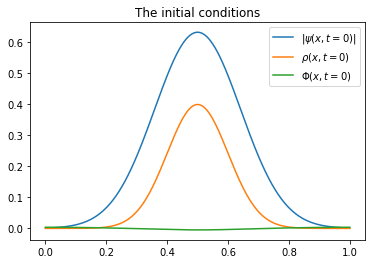

Laplacian after correction [  0.71574868   0.71574868   0.73063293   0.74578163   0.76119838
   0.77688679   0.7928505    0.80909317   0.82561849   0.84243014
   0.85953186   0.87692738   0.89462045   0.91261487   0.9309144
   0.94952288   0.96844411   0.98768193   1.00724021   1.0271228
   1.04733358   1.06787645   1.08875529   1.10997402   1.13153656
   1.15344683   1.17570876   1.19832628   1.22130334   1.24464388
   1.26835186   1.2924312    1.31688587   1.3417198    1.36693695
   1.39254124   1.41853662   1.444927     1.47171632   1.49890847
   1.52650737   1.55451689   1.58294091   1.61178329   1.64104788
   1.67073849   1.70085894   1.731413     1.76240443   1.79383698
   1.82571435   1.85804022   1.89081825   1.92405205   1.95774522
   1.9919013    2.02652381   2.06161623   2.09718198   2.13322447
   2.16974703   2.20675298   2.24424555   2.28222795   2.32070333
   2.35967478   2.39914533   2.43911796   2.47959558   2.52058104
   2.56207712   2.60408653   2.64661192   2.6896558

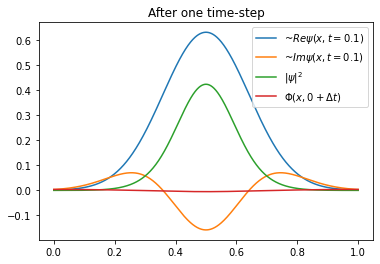

In [182]:
#Build the Initial Condition
N = 1000 #set size
L = 1 #length of periodic box
x = np.linspace(0,L,N) #make x data / grid
dx = L/(N-1)
m = 1
hbar = 1

b=L/2
std=0.1
rho_init = np.array([gauss(xx,b,std) for xx in x])
psi = np.sqrt(rho_init) #assuming psi_init to be real valued and non-negative

phi_init = real_fourier_potential(psi)

#Plot initial conditions
plt.plot(x,psi, label = '$|\\psi(x,t=0)|$')
plt.plot(x,rho_init, label = '$\\rho(x,t=0)$')
plt.plot(x,phi_init, label = '$\\Phi(x,t=0)$')
plt.title("The initial conditions")
plt.legend()
plt.show()

#Evolve the system by one time-step
H_psi = H(psi,phi_init,dx,hbar,m)
#print(H_psi)
Delta_t = 0.01
psi = psi-1j*Delta_t*H_psi #np.dot(H_psi,psi_init) #recalculate psi after the time step


#plt.plot(x,np.dot(H,psi_init), label = '') 
plt.plot(x,np.real(psi),label = '~$Re\\psi(x,t=0.1)$')
plt.plot(x,np.imag(psi),label = '~$Im\\psi(x,t=0.1)$')
plt.plot(x,np.absolute(psi)**2,label = '$|\psi|^2$')
plt.plot(x,real_fourier_potential(psi), label = '$\\Phi(x,0+\\Delta t)$')
plt.title("After one time-step")
plt.legend()
plt.show()

## Trying Again: $\psi(x,t=0) = \sin^2(\pi x/L)$

Laplacian after correction [ 19.73738325  19.73738325  19.73268922  19.72486668  19.71391685
  19.69984148  19.68264279  19.66232352  19.63888688  19.61233659
  19.58267687  19.5499124   19.51404839  19.47509052  19.43304497
  19.38791841  19.33971799  19.28845134  19.23412661  19.1767524
  19.11633781  19.05289242  18.98642629  18.91694995  18.84447442
  18.76901119  18.69057222  18.60916996  18.5248173   18.43752762
  18.34731476  18.25419303  18.15817718  18.05928244  17.95752449
  17.85291946  17.74548394  17.63523496  17.52218999  17.40636697
  17.28778426  17.16646065  17.04241538  16.91566812  16.78623896
  16.65414843  16.51941746  16.38206742  16.24212009  16.09959764
  15.95452268  15.80691821  15.65680763  15.50421474  15.34916373
  15.19167918  15.03178607  14.86950974  14.70487592  14.53791072
  14.3686406   14.19709241  14.02329333  13.84727093  13.66905311
  13.48866813  13.30614459  13.12151143  12.93479791  12.74603364
  12.55524855  12.36247289  12.16773721  11.971072

C:\Users\boris\AppData\Local\Temp\ipykernel_17200\4038483260.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  if math.isnan(H(psi,phi,dx,hbar,m)[0]) == True:


Laplacian after correction [ 19.73738325-5.84642244j  19.73738325-5.84642244j
  19.73268922-3.89736189j  19.72486668-3.895812j
  19.71391685-3.89364268j  19.69984148-3.89085427j
  19.68264279-3.88744722j  19.66232352-3.88342206j
  19.63888688-3.87877945j  19.61233659-3.87352012j
  19.58267687-3.8676449j   19.5499124 -3.86115473j
  19.51404839-3.85405066j  19.47509052-3.84633379j
  19.43304497-3.83800539j  19.38791841-3.82906674j
  19.33971799-3.8195193j   19.28845134-3.80936457j
  19.23412661-3.79860419j  19.1767524 -3.78723985j
  19.11633781-3.77527334j  19.05289242-3.76270666j
  18.98642629-3.74954168j  18.91694995-3.73578061j
  18.84447442-3.7214256j   18.76901119-3.70647889j
  18.69057222-3.69094298j  18.60916996-3.67482018j
  18.5248173 -3.65811325j  18.43752762-3.64082469j
  18.34731476-3.62295734j  18.25419303-3.60451403j
  18.15817718-3.58549769j  18.05928244-3.5659114j
  17.95752449-3.54575817j  17.85291946-3.52504136j
  17.74548394-3.50376416j  17.63523496-3.48193j
  17.52218

C:\Users\boris\AppData\Local\Temp\ipykernel_17200\4038483260.py:44: RuntimeWarning: overflow encountered in square
  rho = np.absolute(psi)**2
C:\Users\boris\AppData\Local\Temp\ipykernel_17200\4038483260.py:45: RuntimeWarning: invalid value encountered in subtract
  P =  rho-np.mean(rho)



Laplacian after correction [ 3.65458208e+171+4.50993458e+168j  3.65458215e+171+4.50993461e+168j
 -6.29296993e+171-6.23395617e+168j  3.02779019e+171+1.33281907e+168j
 -3.22450537e+170+3.59441038e+167j -8.62139539e+169+4.01907333e+163j
  1.01151654e+163+4.35684924e+163j  2.86326282e+163+4.01115267e+163j
 -1.13117562e+163+4.03891991e+163j  3.91913101e+163+3.84403988e+163j
 -7.03063806e+162+3.79230292e+163j  1.28836153e+163+3.64425146e+163j
  2.95640239e+163+3.56885566e+163j -2.78922809e+163+3.43670443e+163j
  5.68387742e+163+3.35522139e+163j -3.78753257e+163+3.23192358e+163j
  5.06650048e+163+3.14598335e+163j -2.52203617e+163+3.03148700e+163j
  1.41218811e+163+2.94245963e+163j  4.59004015e+163+2.84022873e+163j
 -6.96465311e+163+2.74022984e+163j  8.53559799e+163+2.65300537e+163j
 -3.76324921e+163+2.55408151e+163j -2.25883575e+162+2.46207213e+163j
  6.06210401e+163+2.37905472e+163j -8.07742967e+163+2.27966436e+163j
  1.04038058e+164+2.20696757e+163j -8.60729089e+163+2.10868431e+163j
  6.83

C:\Users\boris\AppData\Local\Temp\ipykernel_17200\2700633625.py:58: RuntimeWarning: overflow encountered in square
  P = np.absolute(psi)**2 #this is the density


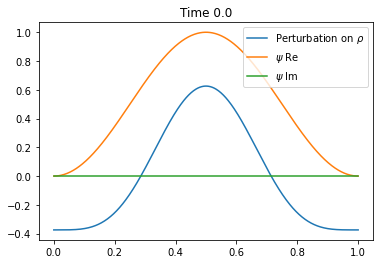

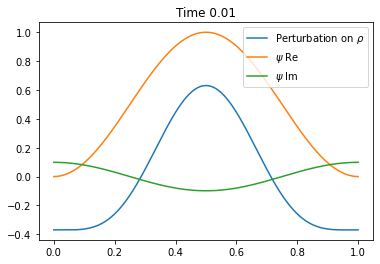

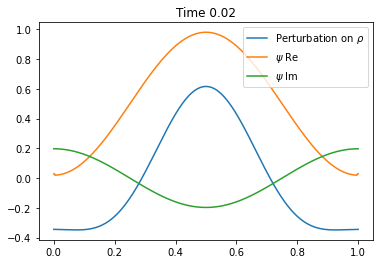

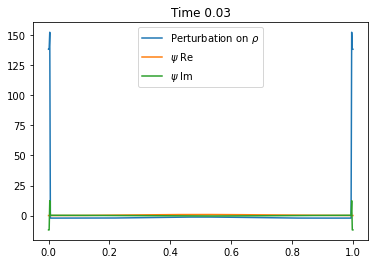

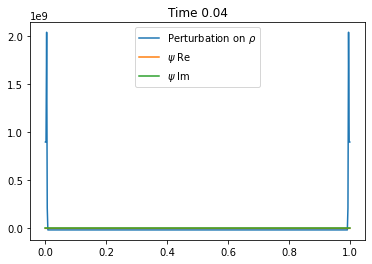

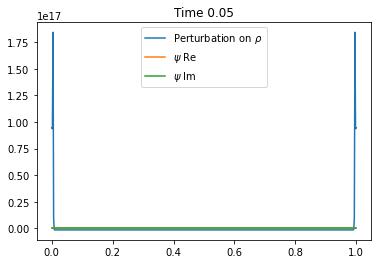

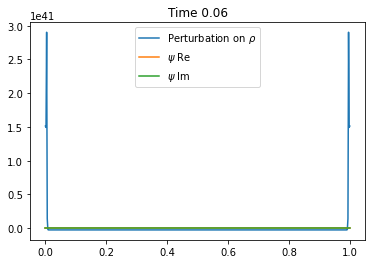

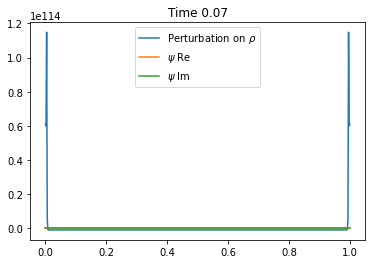

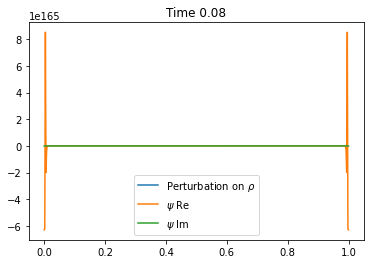

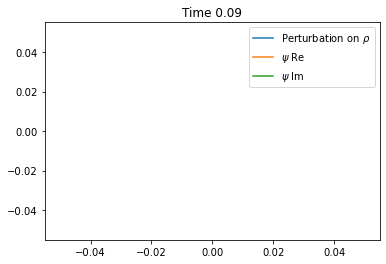

IndexError: index 10 is out of bounds for axis 0 with size 10

In [184]:
#CALCULATION
#Build the Initial Condition
N = 500#set size
L = 1 #length of periodic box
x = np.linspace(0,L,N) #make x data / grid
dx = L/(N-1)
m = 1
hbar = 1

#Let's try this particular psi. 
psi = np.sin(0.5*2*np.pi*x/L)**2
#plt.plot(x,psi,'-',label = '$\\psi(x,t=0)$')
#plt.show()

#calculate initial (perturbation on-) density
rho = np.absolute(psi)**2
rho_avg = np.mean(rho)
P = rho-rho_avg

#storage space, with initial functions
P_s = np.array([P]) #initial density perturbation
psi_s = np.array([psi]) #initial wavefunction


dt = 0.01
t_stop = 10
time = 0
while time <= 10:
    #Calculate the potential phi
    phi = np.real(real_fourier_potential(psi))
    
    #H = H_matrix(phi,dx,hbar,m)
    
    #Calculate the new psi after time step, then store it
    #psi = psi-dt*np.dot(H,psi)*1j
    psi = psi-dt*H(psi,phi,dx,hbar,m)*1j
    print(psi)
    #do this weird correction thing to the boundary points:
    #dx = L/(N-1)
    #psi[0] = psi[-1]
    
    psi_s = np.append(psi_s,[psi], axis=0)
    
    rho = np.absolute(psi)**2
    P =  rho-np.mean(rho)
    P_s = np.append(P_s, [P], axis = 0)

    time += dt #forward on the clock
    if math.isnan(H(psi,phi,dx,hbar,m)[0]) == True:
        break
#plt.figure()
for i in range(15):
    #plt.figure()
    plt.plot(x,P_s[i],label = "Perturbation on $\\rho$")
    plt.plot(x,psi_s[i].real, label = "$\\psi$ Re")
    plt.plot(x,psi_s[i].imag, label = "$\\psi$ Im")
    plt.legend()
    plt.title(f"Time {dt*i}")
    #plt.ylim([-2,3])
    
    #now save it as a .jpg file:
    filename = 'ToyModelPlot' + str(i+1).zfill(3) + '.jpg';
    folder = "ToyModel_Images"
    plt.savefig(folder + "/" + filename)  #save this figure (includes both subplots)
    
    plt.show() #close plot so it doesn't overlap with the next one


#turn it into an animation:    
os.system("ffmpeg -y -i 'ToyModelPlot%03d.jpg' ToyModel.m4v")

from IPython.display import HTML

In [153]:
# importing libraries
import os
import cv2 
from PIL import Image 
  
# Checking the current directory path
print(os.getcwd()) 
  
# Folder which contains all the images
# from which video is to be generated
os.chdir("C:\\Users\\boris\\OneDrive - Queen's University\\Documents\\JOB_Files\\McDonald Institute Fellowship\\Research\\Coding\\ToyModel_Images")  
path = "C:\\Users\\boris\\OneDrive - Queen's University\\Documents\\JOB_Files\\McDonald Institute Fellowship\\Research\\Coding\\ToyModel_Images"
  
mean_height = 0
mean_width = 0
  
num_of_images = len(os.listdir('.'))
# print(num_of_images)
  
for file in os.listdir('.'):
    im = Image.open(os.path.join(path, file))
    width, height = im.size
    mean_width += width
    mean_height += height
    # im.show()   # uncomment this for displaying the image
  
# Finding the mean height and width of all images.
# This is required because the video frame needs
# to be set with same width and height. Otherwise
# images not equal to that width height will not get 
# embedded into the video
mean_width = int(mean_width / num_of_images)
mean_height = int(mean_height / num_of_images)
  
# print(mean_height)
# print(mean_width)
  
# Resizing of the images to give
# them same width and height 
for file in os.listdir('.'):
    if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith("png"):
        # opening image using PIL Image
        im = Image.open(os.path.join(path, file)) 
   
        # im.size includes the height and width of image
        width, height = im.size   
        print(width, height)
  
        # resizing 
        imResize = im.resize((mean_width, mean_height), Image.ANTIALIAS) 
        imResize.save( file, 'JPEG', quality = 120) # setting quality
        # printing each resized image name
        print(im.filename.split('\\')[-1], " is resized") 
  
  
# Video Generating function
def generate_video():
    image_folder = "C:\\Users\\boris\\OneDrive - Queen's University\\Documents\\JOB_Files\\McDonald Institute Fellowship\\Research\\Coding\\ToyModel_Images" # make sure to use your folder
    video_name = 'ToyModel_video.avi'
    os.chdir("C:\\Users\\boris\\OneDrive - Queen's University\\Documents\\JOB_Files\\McDonald Institute Fellowship\\Research\\Coding")
      
    images = [img for img in os.listdir(image_folder)
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png")]
     
    # Array images should only consider
    # the image files ignoring others if any
    print(images) 
  
    frame = cv2.imread(os.path.join(image_folder, images[0]))
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape  
  
    video = cv2.VideoWriter(video_name, 0, 1, (width, height)) 
  
    # Appending the images to the video one by one
    for image in images: 
        video.write(cv2.imread(os.path.join(image_folder, image))) 
      
    # Deallocating memories taken for window creation
    cv2.destroyAllWindows() 
    video.release()  # releasing the video generated
  
  
# Calling the generate_video function
generate_video()

C:\Users\boris\OneDrive - Queen's University\Documents\JOB_Files\McDonald Institute Fellowship\Research\Coding
432 288
ToyModelPlot001.jpg  is resized
432 288
ToyModelPlot002.jpg  is resized
432 288
ToyModelPlot003.jpg  is resized
432 288
ToyModelPlot004.jpg  is resized
432 288
ToyModelPlot005.jpg  is resized
432 288
ToyModelPlot006.jpg  is resized
432 288
ToyModelPlot007.jpg  is resized
432 288
ToyModelPlot008.jpg  is resized
432 288
ToyModelPlot009.jpg  is resized
432 288
ToyModelPlot010.jpg  is resized
432 288
ToyModelPlot011.jpg  is resized
432 288
ToyModelPlot012.jpg  is resized
432 288
ToyModelPlot013.jpg  is resized
432 288
ToyModelPlot014.jpg  is resized
432 288
ToyModelPlot015.jpg  is resized
['ToyModelPlot001.jpg', 'ToyModelPlot002.jpg', 'ToyModelPlot003.jpg', 'ToyModelPlot004.jpg', 'ToyModelPlot005.jpg', 'ToyModelPlot006.jpg', 'ToyModelPlot007.jpg', 'ToyModelPlot008.jpg', 'ToyModelPlot009.jpg', 'ToyModelPlot010.jpg', 'ToyModelPlot011.jpg', 'ToyModelPlot012.jpg', 'ToyModelPlo

## Once More: $\psi(x,t=0) = exp(-x^2/L^2)$

Laplacian after correction [ 6.16105452e+01  7.15748681e-01  7.30632929e-01  7.45781629e-01
  7.61198377e-01  7.76886788e-01  7.92850500e-01  8.09093172e-01
  8.25618486e-01  8.42430141e-01  8.59531858e-01  8.76927377e-01
  8.94620454e-01  9.12614865e-01  9.30914403e-01  9.49522875e-01
  9.68444106e-01  9.87681933e-01  1.00724021e+00  1.02712280e+00
  1.04733358e+00  1.06787645e+00  1.08875529e+00  1.10997402e+00
  1.13153656e+00  1.15344683e+00  1.17570876e+00  1.19832628e+00
  1.22130334e+00  1.24464388e+00  1.26835186e+00  1.29243120e+00
  1.31688587e+00  1.34171980e+00  1.36693695e+00  1.39254124e+00
  1.41853662e+00  1.44492700e+00  1.47171632e+00  1.49890847e+00
  1.52650737e+00  1.55451689e+00  1.58294091e+00  1.61178329e+00
  1.64104788e+00  1.67073849e+00  1.70085894e+00  1.73141300e+00
  1.76240443e+00  1.79383698e+00  1.82571435e+00  1.85804022e+00
  1.89081825e+00  1.92405205e+00  1.95774522e+00  1.99190130e+00
  2.02652381e+00  2.06161623e+00  2.09718198e+00  2.13322447e+0

C:\Users\boris\AppData\Local\Temp\ipykernel_17200\768297153.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  if math.isnan(H(psi,phi,dx,hbar,m)[0]) == True:


Laplacian after correction [ 6.16105452e+01-6.07730683e+05j  7.15748681e-01+3.03939611e+05j
  7.30632929e-01+1.31957494e+00j  7.45781629e-01+1.33750604e+00j
  7.61198377e-01+1.35554957e+00j  7.76886788e-01+1.37370280e+00j
  7.92850500e-01+1.39196295e+00j  8.09093172e-01+1.41032722e+00j
  8.25618486e-01+1.42879254e+00j  8.42430141e-01+1.44735590e+00j
  8.59531858e-01+1.46601400e+00j  8.76927377e-01+1.48476351e+00j
  8.94620454e-01+1.50360119e+00j  9.12614865e-01+1.52252317e+00j
  9.30914403e-01+1.54152608e+00j  9.49522875e-01+1.56060591e+00j
  9.68444106e-01+1.57975884e+00j  9.87681933e-01+1.59898095e+00j
  1.00724021e+00+1.61826775e+00j  1.02712280e+00+1.63761539e+00j
  1.04733358e+00+1.65701915e+00j  1.06787645e+00+1.67647450e+00j
  1.08875529e+00+1.69597710e+00j  1.10997402e+00+1.71552166e+00j
  1.13153656e+00+1.73510375e+00j  1.15344683e+00+1.75471787e+00j
  1.17570876e+00+1.77435930e+00j  1.19832628e+00+1.79402218e+00j
  1.22130334e+00+1.81370148e+00j  1.24464388e+00+1.83339159e+00

C:\Users\boris\AppData\Local\Temp\ipykernel_17200\2317461765.py:69: RuntimeWarning: overflow encountered in multiply
  U_psi = phi*psi


Laplacian after correction [-4.08895713e+213+1.78428710e+217j  3.05357092e+213-1.41972233e+217j
 -1.20645669e+213+6.99721266e+216j  1.96892058e+212-1.96036905e+216j
  4.72281264e+209+2.38484147e+215j  5.78848223e+201+4.59998579e+212j
  5.23141998e+201+8.00880623e+203j  5.47036799e+201-4.95779870e+203j
  5.30259153e+201+4.29280893e+203j  5.47975127e+201-1.20358414e+203j
  5.54186706e+201-4.82009588e+203j  5.22635116e+201+1.11733530e+204j
  5.79354134e+201-1.35303963e+204j  5.26578432e+201+1.13930820e+204j
  5.65565033e+201-6.02885357e+203j  5.54738663e+201-1.13565246e+203j
  5.35343983e+201+8.68401669e+203j  5.83786131e+201-1.32437084e+204j
  5.26378798e+201+1.21172521e+204j  5.65884013e+201-4.84954993e+203j
  5.64797730e+201-5.05387801e+203j  5.24333718e+201+1.28865701e+204j
  5.84941455e+201-1.58325034e+204j  5.20472704e+201+1.55393753e+204j
  5.77329887e+201-1.50365210e+204j  5.15859453e+201+1.51979272e+204j
  5.74556380e+201-1.28188674e+204j  5.29404361e+201+4.96958102e+203j
  5.256

C:\Users\boris\AppData\Local\Temp\ipykernel_17200\768297153.py:36: RuntimeWarning: invalid value encountered in multiply
  psi = psi-1j*dt*H(psi,phi,dx,hbar,m)


Laplacian after correction [nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
 nan+nanj nan+nanj nan+n

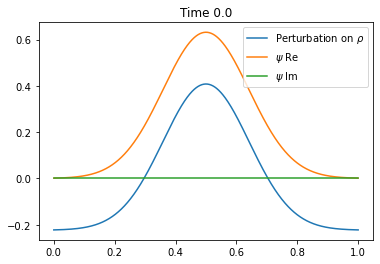

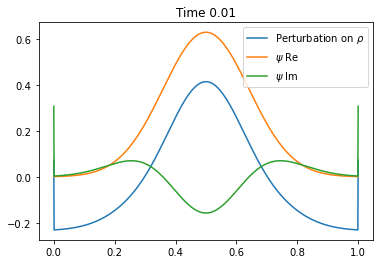

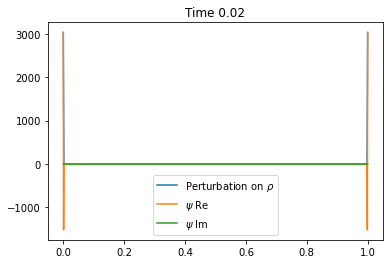

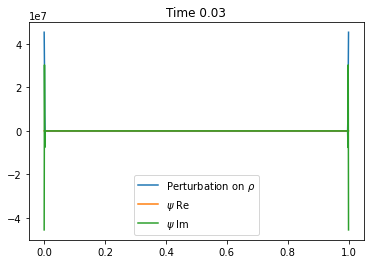

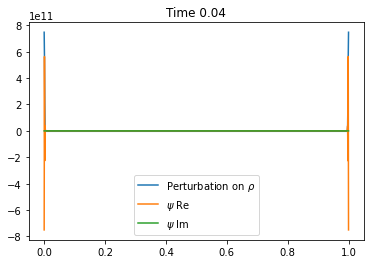

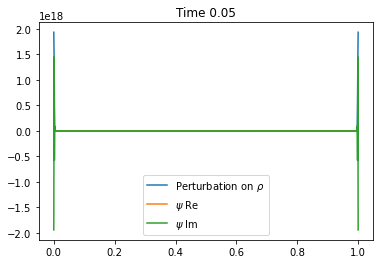

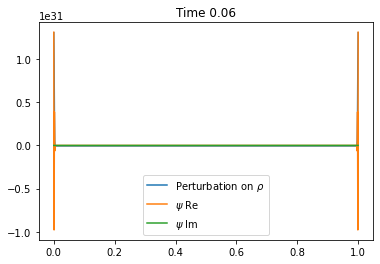

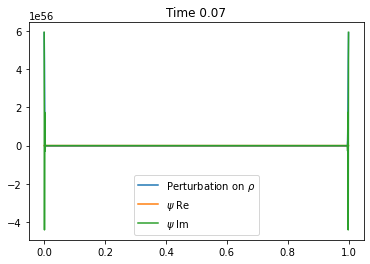

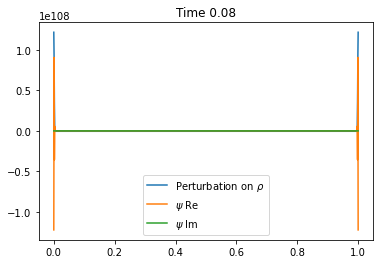

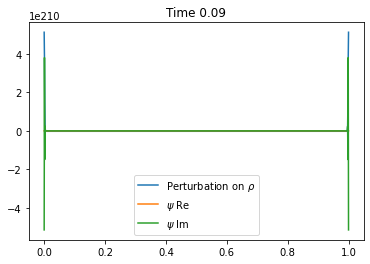

In [ ]:
#CALCULATION
#Build the Initial Condition
N = 1000#set size
L = 1 #length of periodic box
x = np.linspace(0,L,N) #make x data / grid
dx = L/(N-1)
#print(len(x),x[0],x[1],x[-1])

#Let's try this particular psi. 
b=L/2
std=0.1
rho_init = np.array([gauss(xx,b,std) for xx in x])
psi = np.sqrt(rho_init) #assuming psi_init to be real valued and non-negative
plt.show()

#calculate initial (perturbation on-) density
rho = np.absolute(psi)
rho_avg = np.mean(rho)
P = rho-rho_avg

#storage space, with initial functions
P_s = np.array([P]) #initial density perturbation
psi_s = np.array([psi]) #initial wavefunction


dt = 0.01
t_stop = 10
time = 0
while time <= 10:
    #Calculate the potential phi
    phi = np.real(real_fourier_potential(psi))
    
    #H = H_matrix(phi,dx,hbar,m)
    
    #Calculate the new psi after time step, then store it
    psi = psi-1j*dt*H(psi,phi,dx,hbar,m)
    
    #do this weird correction thing to the boundary points:
    #dx = L/(N-1)
    #psi[-1] = psi[0]#psi[1]+(psi[1]-psi[2])
    #psi[-1] = 0#psi[-2] - (psi[-3]-psi[-2])
    
    psi_s = np.append(psi_s,[psi], axis=0)
    
    rho = np.absolute(psi)
    P = rho - np.mean(rho)
    P_s = np.append(P_s, [P], axis = 0)

    time += dt #forward on the clock
    if math.isnan(H(psi,phi,dx,hbar,m)[0]) == True:
        break

for i in range(int(time//dt)+1):
    plt.plot(x,P_s[i].real,label = "Perturbation on $\\rho$")
    plt.plot(x,psi_s[i].real, label = "$\\psi$ Re")
    plt.plot(x,psi_s[i].imag, label = "$\\psi$ Im")
    plt.legend()
    plt.title(f"Time {dt*i}")
    plt.show()